In [1]:
# Define orbital parameters for the GEO satellite
# Units: semi-major axis in kilometers, angles in degrees
geo_a = 42164.0  # Semi-major axis (km) for GEO
geo_e = 0.001    # Eccentricity
geo_i = 0.05     # Inclination (degrees)
geo_raan = 0.0   # Right Ascension of the Ascending Node (degrees)
geo_argp = 0.0   # Argument of Perigee (degrees)
geo_ta = 0.0     # True Anomaly (degrees)

# Define orbital parameters for the MEO satellite
# Units: semi-major axis in kilometers, angles in degrees
meo_a = 26560.0  # Semi-major axis (km) for MEO (e.g., GPS orbit)
meo_e = 0.001    # Eccentricity
meo_i = 55.0     # Inclination (degrees)
meo_raan = 0.0   # Right Ascension of the Ascending Node (degrees)
meo_argp = 0.0   # Argument of Perigee (degrees)
meo_ta = 0.0     # True Anomaly (degrees)

In [3]:
import numpy as np
from astropy.coordinates import EarthLocation, AltAz, SkyCoord, GCRS, CartesianRepresentation
from astropy import units as u
from astropy.time import Time

# Define a reference epoch
epoch = Time('2023-01-01 00:00:00', scale='utc')

# Convert angles from degrees to radians for calculations
geo_i_rad = np.deg2rad(geo_i)
geo_raan_rad = np.deg2rad(geo_raan)
geo_argp_rad = np.deg2rad(geo_argp)
geo_ta_rad = np.deg2rad(geo_ta)

meo_i_rad = np.deg2rad(meo_i)
meo_raan_rad = np.deg2rad(meo_raan)
meo_argp_rad = np.deg2rad(meo_argp)
meo_ta_rad = np.deg2rad(meo_ta)

# Calculate the position vectors for both satellites
# Using astropy's GCRS to represent positions in a geocentric frame
# Note: Astropy does not have a direct function to get position from orbital elements
# without propagating the orbit. For a single point in time, we can construct
# the position vector in the orbital plane and then rotate it.
# A simpler approach for a single point in time is to use keplerian elements
# and convert them to cartesian coordinates. We will use a simplified approach here.

# Simplified calculation of radial distance and position in orbital plane
geo_r = geo_a * (1 - geo_e**2) / (1 + geo_e * np.cos(geo_ta_rad))
meo_r = meo_a * (1 - meo_e**2) / (1 + meo_e * np.cos(meo_ta_rad))

# Position in the orbital plane (in the perifocal frame)
geo_pos_perifocal = np.array([geo_r * np.cos(geo_ta_rad), geo_r * np.sin(geo_ta_rad), 0])
meo_pos_perifocal = np.array([meo_r * np.cos(meo_ta_rad), meo_r * np.sin(meo_ta_rad), 0])

# Rotation to GCRS (simplified, assuming no time evolution of orbital elements)
# This is a simplified rotation matrix from perifocal to GCRS (assuming J2000 orientation)
# A more rigorous approach would involve a sequence of rotations:
# Perifocal -> Orbital plane -> Node frame -> ECI (GCRS)
# For this simplified task, we'll construct a rotation matrix directly
# from RAAN, inclination, and argument of perigee.

# Constructing the rotation matrix (simplified for a single point in time)
# This matrix rotates a vector from the perifocal frame to the GCRS frame
def perifocal_to_GCRS(raan, inc, argp):
    # Correct rotation matrix from perifocal to ECI (GCRS)
    R3_argp = np.array([[np.cos(argp), -np.sin(argp), 0],
                        [np.sin(argp), np.cos(argp), 0],
                        [0, 0, 1]])

    R1_inc = np.array([[1, 0, 0],
                       [0, np.cos(inc), -np.sin(inc)],
                       [0, np.sin(inc), np.cos(inc)]])

    R3_raan = np.array([[np.cos(raan), -np.sin(raan), 0],
                        [np.sin(raan), np.cos(raan), 0],
                        [0, 0, 1]])

    # Combined rotation matrix: R = R3(RAAN) * R1(Inclination) * R3(Argument of Perigee)
    R = R3_raan @ R1_inc @ R3_argp
    return R

# Apply the rotation to get position vectors in GCRS
geo_pos_GCRS = perifocal_to_GCRS(geo_raan_rad, geo_i_rad, geo_argp_rad) @ geo_pos_perifocal
meo_pos_GCRS = perifocal_to_GCRS(meo_raan_rad, meo_i_rad, meo_argp_rad) @ meo_pos_perifocal

# Store the calculated position vectors using CartesianRepresentation
geo_satellite_position = SkyCoord(CartesianRepresentation(geo_pos_GCRS[0]*u.km, geo_pos_GCRS[1]*u.km, geo_pos_GCRS[2]*u.km), frame=GCRS(obstime=epoch))
meo_satellite_position = SkyCoord(CartesianRepresentation(meo_pos_GCRS[0]*u.km, meo_pos_GCRS[1]*u.km, meo_pos_GCRS[2]*u.km), frame=GCRS(obstime=epoch))

print("GEO Satellite Position (GCRS):", geo_satellite_position.cartesian)
print("MEO Satellite Position (GCRS):", meo_satellite_position.cartesian)

GEO Satellite Position (GCRS): (42121.836, 0., 0.) km
MEO Satellite Position (GCRS): (26533.44, 0., 0.) km


In [10]:
from astropy import units as u
from astropy.time import Time
import numpy as np

# Ensure epoch is an Astropy Time object
epoch = Time('2023-01-01 00:00:00', scale='utc')

# Define the time period for the animation
start_time = epoch  # Use the same epoch as the initial position calculations
end_time = start_time + 6 * u.hour  # Define the end time, e.g., 6 hours later

# Define the number of time steps for the animation
num_steps = 200  # Increase the number of steps for a smoother animation

# Create an array of time objects for each step
times = start_time + (end_time - start_time) * np.linspace(0, 1, num_steps)

print("Animation start time:", start_time)
print("Animation end time:", end_time)
print("Number of steps:", num_steps)
print("First few time steps:", times[:5])

Animation start time: 2023-01-01 00:00:00.000
Animation end time: 2023-01-01 06:00:00.000
Number of steps: 200
First few time steps: ['2023-01-01 00:00:00.000' '2023-01-01 00:01:48.543'
 '2023-01-01 00:03:37.085' '2023-01-01 00:05:25.628'
 '2023-01-01 00:07:14.171']


In [12]:
%pip install poliastro

Requested poliastro from https://files.pythonhosted.org/packages/1c/ce/b2cf237afeacddd856bb3ae524c44b8aec62e14c13d137283122fd0b5099/poliastro-0.12.0-py3-none-any.whl has invalid metadata: .* suffix can only be used with `==` or `!=` operators
    astropy (<4.*,>=3.1)
             ~~~^
Please use pip<24.1 if you need to use this version.
Requested poliastro from https://files.pythonhosted.org/packages/f7/9a/934e863eee7acca4648b3570085da982cde69969527b9f4d7a0445f16789/poliastro-0.11.1-py3-none-any.whl has invalid metadata: .* suffix can only be used with `==` or `!=` operators
    astropy (<4.*,>=3.0)
             ~~~^
Please use pip<24.1 if you need to use this version.
Requested poliastro from https://files.pythonhosted.org/packages/31/7d/55cfd3a348ed5575d0468e26c65c35295fc743c28598ba790561e065a263/poliastro-0.11.0-py3-none-any.whl has invalid metadata: .* suffix can only be used with `==` or `!=` operators
    astropy (<4.*,>=3.0)
             ~~~^
Please use pip<24.1 if you need to u

In [16]:
from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from astropy import units as u
import numpy as np # Import numpy if not already imported

# Define a function to propagate orbit
def propagate_orbit(a, e, i, raan, argp, argp_unit, ta, ta_unit, epoch, target_time):
    # Create an Orbit object using poliastro
    # Note: poliastro expects angles in degrees and semi-major axis in km
    # We need to convert our initial parameters to appropriate units if they aren't already
    # Our initial parameters are already in km and degrees as defined earlier

    orbit = Orbit.from_classical(
        Earth,           # Central body is Earth
        a * u.km,        # Semi-major axis
        e * u.one,       # Eccentricity (dimensionless)
        i * u.deg,       # Inclination
        raan * u.deg,    # Right Ascension of Ascending Node
        argp * argp_unit,    # Argument of Perigee with explicit unit
        ta * ta_unit,      # True Anomaly with explicit unit
        epoch=epoch      # Epoch of the orbital elements
    )

    # Calculate the time of flight from the epoch to the target time
    time_of_flight = target_time - epoch

    # Propagate the orbit to the target time using the calculated time of flight
    propagated_orbit = orbit.propagate(time_of_flight)


    # Return the position vector in GCRS (Cartesian coordinates)
    # poliastro's position is in the same frame as the input state, which is typically GCRS
    return propagated_orbit.r # This is already a Quantity

# Initialize lists to store propagated positions
geo_positions_list = []
meo_positions_list = []

# Iterate through each time step and propagate the orbits
for time_step in times:
    # Propagate GEO satellite position
    # Pass the units explicitly for argument of perigee and true anomaly
    geo_pos = propagate_orbit(geo_a, geo_e, geo_i, geo_raan, geo_argp, u.deg, geo_ta, u.deg, epoch, time_step)
    geo_positions_list.append(geo_pos)

    # Propagate MEO satellite position
    # Pass the units explicitly for argument of perigee and true anomaly
    meo_pos = propagate_orbit(meo_a, meo_e, meo_i, meo_raan, meo_argp, u.deg, meo_ta, u.deg, epoch, time_step)
    meo_positions_list.append(meo_pos)

# Extract values and stack them, then create a Quantity with the correct unit
geo_positions_values = np.stack([pos.value for pos in geo_positions_list], axis=1)
meo_positions_values = np.stack([pos.value for pos in meo_positions_list], axis=1)

# Assuming the positions returned by poliastro are in km, apply the unit
geo_positions = geo_positions_values * u.km
meo_positions = meo_positions_values * u.km


# Print the first few propagated positions to verify
print("First 5 propagated GEO Satellite Positions (GCRS):")
print(geo_positions[:, :5])

print("\nFirst 5 propagated MEO Satellite Positions (GCRS):")
print(meo_positions[:, :5])

First 5 propagated GEO Satellite Positions (GCRS):
[[4.21218360e+04 4.21205126e+04 4.21165425e+04 4.21099259e+04
  4.21006632e+04]
 [0.00000000e+00 3.34062896e+02 6.68104800e+02 1.00210472e+03
  1.33604168e+03]
 [0.00000000e+00 2.91524946e-01 5.83031573e-01 8.74501565e-01
  1.16591661e+00]] km

First 5 propagated MEO Satellite Positions (GCRS):
[[26533.44       26530.10486909 26520.10031728 26503.42886717
  26480.09472235]
 [    0.           241.41426375   482.76783822   724.00004951
    965.05025451]
 [    0.           344.77529958   689.46392587  1033.97922759
   1378.23459738]] km


In [17]:
# Calculate the line of sight vector by subtracting the GEO positions from the MEO positions
# geo_positions and meo_positions are astropy.units.Quantity objects with shape (3, num_steps)
# Direct subtraction is possible due to compatible shapes and units.
line_of_sight_vectors = meo_positions - geo_positions

# Print the first few calculated line of sight vectors to verify the result.
print("First 5 calculated Line of Sight Vectors (MEO to GEO):")
print(line_of_sight_vectors[:, :5])

First 5 calculated Line of Sight Vectors (MEO to GEO):
[[-15588.396      -15590.40772746 -15596.44215233 -15606.49700222
  -15620.56849055]
 [     0.            -92.64863187   -185.33696154   -278.10467275
    -370.99142112]
 [     0.            344.48377463    688.8808943    1033.10472602
    1377.06868078]] km


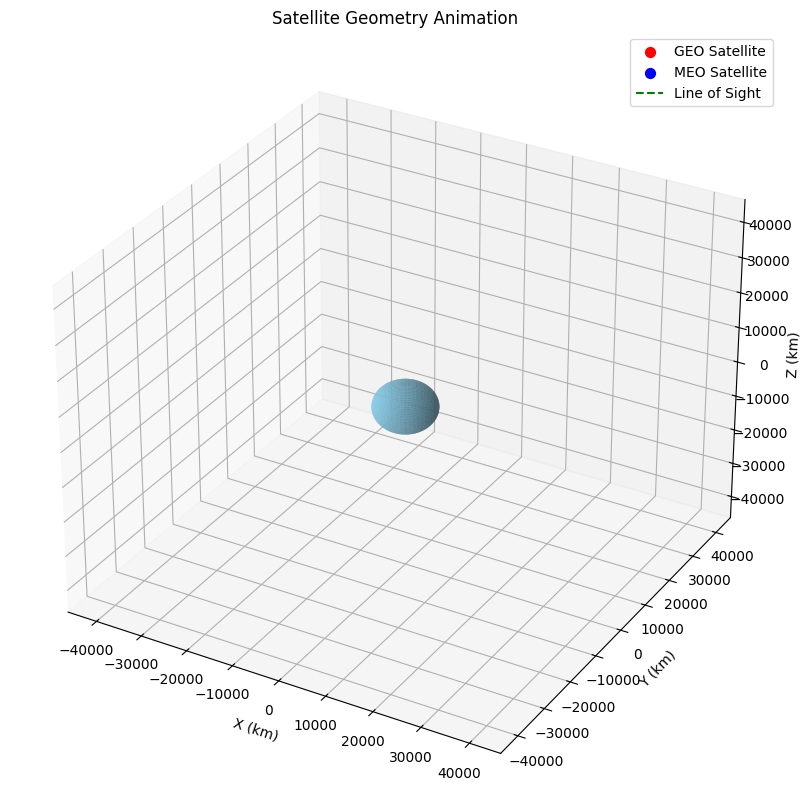

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

# Define Earth radius
earth_radius = 6371.0  # kilometers

# Compute orbit extent
max_orbit_radius = np.max([
    np.linalg.norm(geo_positions.value, axis=0),
    np.linalg.norm(meo_positions.value, axis=0)
])
max_range = max_orbit_radius * 1.1

# Create figure and 3D axis
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

# Draw Earth once
u_earth, v_earth = np.mgrid[0:2*np.pi:100j, 0:np.pi:100j]
x_earth = earth_radius * np.cos(u_earth) * np.sin(v_earth)
y_earth = earth_radius * np.sin(u_earth) * np.sin(v_earth)
z_earth = earth_radius * np.cos(v_earth)
ax.plot_surface(x_earth, y_earth, z_earth, color="skyblue", alpha=0.8)

# Scatter placeholders
geo_scatter = ax.scatter([], [], [], color="red", s=50, label="GEO Satellite")
meo_scatter = ax.scatter([], [], [], color="blue", s=50, label="MEO Satellite")
line_of_sight, = ax.plot([], [], [], color="green", linestyle="--", label="Line of Sight")

# Configure axes
ax.set_xlim([-max_range, max_range])
ax.set_ylim([-max_range, max_range])
ax.set_zlim([-max_range, max_range])
ax.set_xlabel("X (km)")
ax.set_ylabel("Y (km)")
ax.set_zlabel("Z (km)")
ax.legend()
ax.set_title("Satellite Geometry Animation")

# Update function
def update(i):
    # Update scatter points
    geo_scatter._offsets3d = (
        [geo_positions[0, i].value],
        [geo_positions[1, i].value],
        [geo_positions[2, i].value]
    )
    meo_scatter._offsets3d = (
        [meo_positions[0, i].value],
        [meo_positions[1, i].value],
        [meo_positions[2, i].value]
    )

    # Update line of sight
    line_of_sight.set_data(
        [meo_positions[0, i].value, geo_positions[0, i].value],
        [meo_positions[1, i].value, geo_positions[1, i].value]
    )
    line_of_sight.set_3d_properties(
        [meo_positions[2, i].value, geo_positions[2, i].value]
    )

    ax.set_title(f"Satellite Geometry at Time Step {i+1}/{num_steps}")
    return geo_scatter, meo_scatter, line_of_sight

# Create animation
ani = FuncAnimation(fig, update, frames=num_steps, interval=100, blit=False)

# Show inline (Jupyter) or save
plt.show()
# ani.save("satellite_animation.mp4", writer="ffmpeg", fps=30)
